In [10]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, LassoCV,LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 30)

#sns.set_style("whitegrid")
#plt.style.use('bmh')
plt.style.use('seaborn-whitegrid')

# this allows plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [11]:
train_df = pd.read_csv('data/train.csv')
train_df['data_set'] = 'train'
test_df = pd.read_csv('data/test.csv')
test_df['data_set'] = 'test'
# combine train and test data into one df
test_df['registered'] = 0
test_df['casual'] = 0
test_df['count'] = 0

all_df = pd.concat([train_df, test_df])
# parse datetime colum & add new time related columns
dt = pd.DatetimeIndex(all_df['datetime'])
all_df.set_index(dt, inplace=True)

# logarithmic transformation of dependent cols
# (adding 1 first so that 0 values don't become -inf)
for col in ['casual', 'registered', 'count']:
    all_df[f'{col}_log'] = np.log(all_df[col] + 1)

all_df['date'] = dt.date # yyyymmdd
all_df['day'] = dt.day # dd
all_df['month'] = dt.month # mm
all_df['year'] = dt.year # yyyy
all_df['hour'] = dt.hour # hh
all_df['dow'] = dt.dayofweek #曜日 Mon:0 Tue:1 Wed:2 Thu:3 Fri:4 Sat:5 Sun:6
all_df['woy'] = dt.isocalendar().week #その日の週が年間で見ると何番目の週かを表す数字 [dt.weekofyear]は deprecated

# feature engineer a new column whether its a peak hour or not
all_df['peak'] = all_df[['hour', 'workingday']]\
    .apply(lambda df: 3 if ((df['workingday'] == 1 and (df['hour'] == 8 or 17 <= df['hour'] <= 18)) \
                            or (df['workingday'] == 0 and 11 <= df['hour'] <= 17)) else \
                            ( 2 if ((df['workingday'] == 1 and (df['hour'] == 7 or df['hour'] == 9 or df['hour'] == 16 or 19 <= df['hour'] <= 20)) \
                            or (df['workingday'] == 0 and (df['hour'] == 10 or 18 <= df['hour'] <= 19))) else \
                            ( 1 if ((df['workingday'] == 1 and (10 <= df['hour'] <= 15 or 21 <= df['hour'] <= 22)) \
                            or (df['workingday'] == 0 and (8 <= df['hour'] <= 9 or 20 <= df['hour'] <= 23))) else 0)), axis = 1)

#ここの修正の仕方は、間違っているので要修正！
# sandy
#all_df['holiday'] = all_df[['month', 'day', 'holiday', 'year']]\
#    .apply(lambda df: 1 if (df['year'] == 2012 and df['month'] == 10 and df['day'] == 30) else 0, axis = 1)
# 修正後↓
all_df['holiday'] = all_df[['month', 'day', 'holiday', 'year']]\
    .apply(lambda df: 1 if (df['year'] == 2012 and df['month'] == 10 and df['day'] == 30) else df['holiday'], axis = 1)


# christmas and others
all_df['holiday'] = all_df[['month', 'day', 'holiday']]\
    .apply(lambda df: 1 if (df['month'] == 12 and df['day'] in [24, 26, 31]) else df['holiday'], axis = 1)
all_df['workingday'] = all_df[['month', 'day', 'workingday']]\
    .apply(lambda df: 0 if df['month'] == 12 and df['day'] in [24, 31] else df['workingday'], axis = 1)
# これは流石に気づかない気がする。。。気づけない気がする。。。
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")

# tax day
all_df.loc[get_day(datetime(2011, 4, 15)), "workingday"] = 1
all_df.loc[get_day(datetime(2012, 4, 16)), "workingday"] = 1

# thanksgiving friday
all_df.loc[get_day(datetime(2011, 11, 25)), "workingday"] = 0
all_df.loc[get_day(datetime(2012, 11, 23)), "workingday"] = 0

# tax day
all_df.loc[get_day(datetime(2011, 4, 15)), "holiday"] = 0
all_df.loc[get_day(datetime(2012, 4, 16)), "holiday"] = 0

# thanksgiving friday
all_df.loc[get_day(datetime(2011, 11, 25)), "holiday"] = 1
all_df.loc[get_day(datetime(2012, 11, 23)), "holiday"] = 1

#storms
all_df.loc[get_day(datetime(2012, 5, 21)), "holiday"] = 1

#tornado
all_df.loc[get_day(datetime(2012, 6, 1)), "holiday"] = 1
# from histogram
all_df['ideal'] = all_df[['temp', 'windspeed']]\
    .apply(lambda df: 1 if (df['temp'] > 27 and df['windspeed'] < 30) else 0, axis = 1)
    
all_df['wet'] = all_df[['humidity', 'workingday']]\
    .apply(lambda df: 1 if (df['workingday'] == 1 and df['humidity'] >= 60) else 0, axis = 1)

# temperature
all_df.loc[all_df['temp'] < 10,'temp_cat'] = 1
all_df.loc[(all_df['temp'] >= 10) & (all_df['temp'] < 15),'temp_cat'] = 2
all_df.loc[(all_df['temp'] >= 15) & (all_df['temp'] < 20),'temp_cat'] = 3
all_df.loc[(all_df['temp'] >= 20) & (all_df['temp'] < 25),'temp_cat'] = 4
all_df.loc[(all_df['temp'] >= 25) & (all_df['temp'] < 30),'temp_cat'] = 5
all_df.loc[(all_df['temp'] >= 30) & (all_df['temp'] < 35),'temp_cat'] = 6
all_df.loc[(all_df['temp'] >= 35),'temp_cat'] = 7

# humidity many category
all_df.loc[all_df['humidity'] < 10,'humidity_cat'] = 0
all_df.loc[(all_df['humidity'] >= 10) & (all_df['humidity'] < 20),'humidity_cat'] = 1
all_df.loc[(all_df['humidity'] >= 20) & (all_df['humidity'] < 30),'humidity_cat'] = 2
all_df.loc[(all_df['humidity'] >= 30) & (all_df['humidity'] < 40),'humidity_cat'] = 3
all_df.loc[(all_df['humidity'] >= 40) & (all_df['humidity'] < 50),'humidity_cat'] = 4
all_df.loc[(all_df['humidity'] >= 50) & (all_df['humidity'] < 60),'humidity_cat'] = 5
all_df.loc[(all_df['humidity'] >= 60) & (all_df['humidity'] < 70),'humidity_cat'] = 6
all_df.loc[(all_df['humidity'] >= 70) & (all_df['humidity'] < 80),'humidity_cat'] = 7
all_df.loc[(all_df['humidity'] >= 80) & (all_df['humidity'] < 90),'humidity_cat'] = 8
all_df.loc[(all_df['humidity'] >= 90),'humidity_cat'] = 9

# windspeed
all_df.loc[all_df['windspeed'] < 5,'wind_cat'] = 0
all_df.loc[(all_df['windspeed'] >= 5) & (all_df['windspeed'] < 10),'wind_cat'] = 1
all_df.loc[(all_df['windspeed'] >= 10) & (all_df['windspeed'] < 15),'wind_cat'] = 2
all_df.loc[(all_df['windspeed'] >= 15) & (all_df['windspeed'] < 20),'wind_cat'] = 3
all_df.loc[(all_df['windspeed'] >= 20) & (all_df['windspeed'] < 25),'wind_cat'] = 4
all_df.loc[(all_df['windspeed'] >= 25) & (all_df['windspeed'] < 30),'wind_cat'] = 5
all_df.loc[(all_df['windspeed'] >= 30) & (all_df['windspeed'] < 35),'wind_cat'] = 6
all_df.loc[(all_df['windspeed'] >= 35) & (all_df['windspeed'] < 40),'wind_cat'] = 7
all_df.loc[(all_df['windspeed'] >= 40) & (all_df['windspeed'] < 45),'wind_cat'] = 8
all_df.loc[(all_df['windspeed'] >= 45),'wind_cat'] = 9


In [12]:
all_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_set,casual_log,registered_log,count_log,date,day,month,year,hour,dow,woy,peak,ideal,wet,temp_cat,humidity_cat,wind_cat
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train,1.386294,2.639057,2.833213,2011-01-01,1,1,2011,0,5,52,0,0,0,1.0,8.0,0.0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train,2.197225,3.496508,3.713572,2011-01-01,1,1,2011,1,5,52,0,0,0,1.0,8.0,0.0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train,1.791759,3.332205,3.496508,2011-01-01,1,1,2011,2,5,52,0,0,0,1.0,8.0,0.0


In [13]:
all_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'data_set', 'casual_log', 'registered_log', 'count_log', 'date', 'day',
       'month', 'year', 'hour', 'dow', 'woy', 'peak', 'ideal', 'wet',
       'temp_cat', 'humidity_cat', 'wind_cat'],
      dtype='object')

In [14]:
# instead of randomly splitting our training data 
# for cross validation, let's construct a framework that's more
# in line with how the data is divvied up for this competition
# (given first 19 days of each month, what is demand for remaining days)
# so, let's split our training data into 2 time contiguous datasets
# for fitting and validating our model (days 1-14 vs. days 15-19).

# also, since submissions are evaluated based on the
# root mean squared logarithmic error (RMSLE), let's replicate
# that computation as we test and tune our model.

train_df = all_df[all_df['data_set'] == 'train']
test_df = all_df[all_df['data_set'] == 'test']

def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

def custom_train_valid_split(data, cutoff_day=15):
    train = data[data['day'] <= cutoff_day]
    valid = data[data['day'] > cutoff_day]

    return train, valid

def prep_train_data(data, input_cols):
    X = data[input_cols].values
    y_r = data['registered_log'].values
    y_c = data['casual_log'].values

    return X, y_r, y_c

# predict on validation set & transform output back from log scale
def predict_on_validation_set(model, input_cols):
    
    train, valid = custom_train_valid_split(train_df)
    y_pred_comb_l = []
    y_actual_comb_l = []

    for year_val in [2011,2012]:
        for month_val in range(1,13):

            ##print(f'Now,{year_val} {month_val} training and validating...')
            # prepare training & validation set
            train_tmp = train.query('year <= @year_val and month <= @month_val')
            valid_tmp = valid.query('year == @year_val and month == @month_val')

            X_train, y_train_r, y_train_c = prep_train_data(train_tmp, input_cols)
            X_valid, y_valid_r, y_valid_c = prep_train_data(valid_tmp, input_cols)

            # training and validating
            model_r = model.fit(X_train, y_train_r)
            y_pred_r = np.exp(model_r.predict(X_valid)) - 1

            model_c = model.fit(X_train, y_train_c)
            y_pred_c = np.exp(model_c.predict(X_valid)) - 1

            y_pred_comb = np.round(y_pred_r + y_pred_c)
            y_pred_comb[y_pred_comb < 0] = 0
            y_pred_comb_l.extend(y_pred_comb)

            y_actual_comb = np.exp(y_valid_r) + np.exp(y_valid_c) - 2
            y_actual_comb_l.extend(y_actual_comb)

            #rmsle = get_rmsle(y_pred_comb, y_actual_comb)
            #rmsle_l.append(rmsle)
    
    rmsle = get_rmsle(np.array(y_pred_comb_l),np.array(y_actual_comb_l))
    
    return (np.array(y_pred_comb_l), np.array(y_actual_comb_l), rmsle)


# predict on test set & transform output back from log scale
def predict_on_test_set(model, input_cols):
    
    y_pred_comb_l = []
    for year_val in [2011,2012]:
        for month_val in range(1,13):
            
            # prepare training set
            print(f'Now,{year_val} {month_val} testing...')
            train_df_tmp = train_df.query('year <= @year_val and month <= @month_val')
            test_df_tmp = test_df.query('year == @year_val and month == @month_val')

            X_train, y_train_r, y_train_c = prep_train_data(train_df_tmp, input_cols)

            # prepare testing set
            X_test = test_df_tmp[input_cols].values
            
            model_c = model.fit(X_train, y_train_c)
            y_pred_c = np.exp(model_c.predict(X_test)) - 1

            model_r = model.fit(X_train, y_train_r)
            y_pred_r = np.exp(model_r.predict(X_test)) - 1
            
            # add casual & registered predictions together
            y_pred_comb = np.round(y_pred_r + y_pred_c)
            y_pred_comb[y_pred_comb < 0] = 0
            y_pred_comb_l.extend(y_pred_comb)

    
    return np.array(y_pred_comb_l)

In [15]:
#params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}

rf_cols = [
    #'weather', 'temp', 'atemp', 'windspeed',
    'weather', 'temp_cat', 'wind_cat',
    'workingday', 'season', 'holiday', 'sticky',
    #'workingday', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'holiday', 'sticky',
    'hour', 'dow', 'woy', 'peak'
    ]

n_estimators = [500]
max_features = [11]
min_samples_split = [10]
max_depth = [10]
best_n_est = 0
best_max_feat = 0
best_min_sam = 0
best_max_dep = 0
best_score_rf = 10
best_rf_pred = []

for n_est in n_estimators:
    for max_feat in max_features:
        for min_sam in min_samples_split:
            for max_dep in max_depth:
                print(f'n_est: {n_est}  max_feat:{max_feat}  min_sam:{min_sam}  max_dep:{max_dep}')
                rf_model = RandomForestRegressor(n_estimators=n_est,max_features=max_feat,min_samples_split=min_sam,max_depth=max_dep,random_state=0,n_jobs=-1)
                (rf_pred, rf_actual, rf_rmsle) = predict_on_validation_set(rf_model, rf_cols)
                print(rf_rmsle)
                if rf_rmsle < best_score_rf:
                    best_score_rf = rf_rmsle
                    best_n_est = n_est
                    best_max_feat = max_feat
                    best_min_sam = min_sam
                    best_max_dep = max_dep
                    best_rf_pred = rf_pred

print(f'rf_pred.shape: {best_rf_pred.shape}   rf_actual.shape: {rf_actual.shape}   rf_rmsle: {best_score_rf}')
print(f'n_est: {best_n_est}  max_feat:{best_max_feat}  min_sam:{best_min_sam}  max_dep:{best_max_dep}')

n_est: 1000  max_dep:15  min_sam:5
0.4155804886847993
rf_pred.shape: (2286,)   rf_actual.shape: (2286,)   rf_rmsle: 0.4155804886847993
n_est: 1000  max_dep:15  min_sam:5


In [16]:
temp_trn_df,temp_val_df = custom_train_valid_split(train_df)
submit_rf_df = temp_val_df[['datetime', 'count']].copy()
submit_rf_df['count'] = best_rf_pred
submit_rf_df.to_csv('output2/submit_rf_val_20211022_1.csv', index=False)

In [17]:
rf_model = RandomForestRegressor(n_estimators=best_n_est,max_features=best_max_feat,min_samples_split=best_min_sam,max_depth=best_max_dep,random_state=0,n_jobs=-1)

rf_pred = predict_on_test_set(rf_model, rf_cols)

# output predictions for submission
submit_rf_df = test_df[['datetime', 'count']].copy()
submit_rf_df['count'] = rf_pred
submit_rf_df.to_csv('output2/submit_rf_20211022_1.csv', index=False)



Now,2011 1 testing...
Now,2011 2 testing...
Now,2011 3 testing...
Now,2011 4 testing...
Now,2011 5 testing...
Now,2011 6 testing...
Now,2011 7 testing...
Now,2011 8 testing...
Now,2011 9 testing...
Now,2011 10 testing...
Now,2011 11 testing...
Now,2011 12 testing...
Now,2012 1 testing...
Now,2012 2 testing...
Now,2012 3 testing...
Now,2012 4 testing...
Now,2012 5 testing...
Now,2012 6 testing...
Now,2012 7 testing...
Now,2012 8 testing...
Now,2012 9 testing...
Now,2012 10 testing...
Now,2012 11 testing...
Now,2012 12 testing...


In [18]:
all_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_set,casual_log,registered_log,count_log,date,day,month,year,hour,dow,woy,peak,ideal,wet,temp_cat,humidity_cat,wind_cat
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train,1.386294,2.639057,2.833213,2011-01-01,1,1,2011,0,5,52,0,0,0,1.0,8.0,0.0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train,2.197225,3.496508,3.713572,2011-01-01,1,1,2011,1,5,52,0,0,0,1.0,8.0,0.0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train,1.791759,3.332205,3.496508,2011-01-01,1,1,2011,2,5,52,0,0,0,1.0,8.0,0.0


array([0.01799045, 0.02117788, 0.01173652, 0.05144888, 0.02835648,
       0.00109429, 0.0029299 , 0.38366888, 0.02849964, 0.04053462,
       0.41256245])

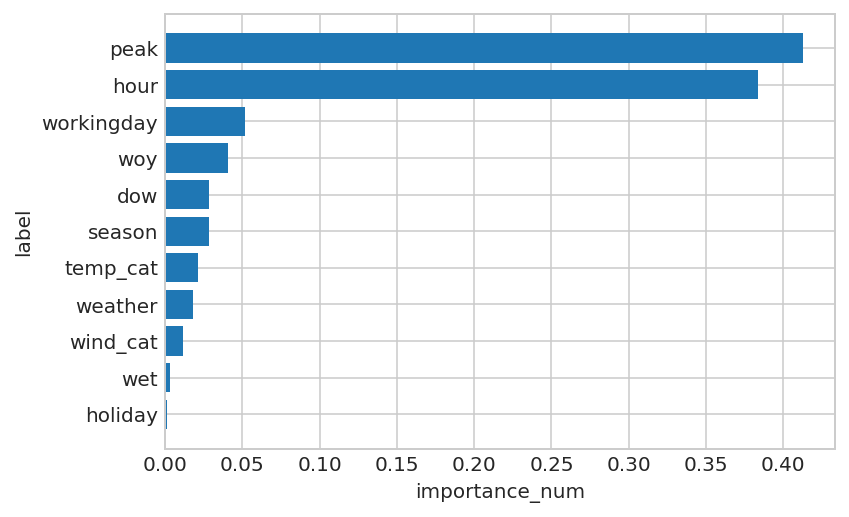